In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field


In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(model = "gpt-4o-mini")

In [4]:
# defining schema for structured output

class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description="sentiment of review")

In [14]:
# structured schema for diagnosis of negative response

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX" "Performance","Bug","Support","Other"] = Field(description="The category of issue mentioned in the review")
    tone: Literal["angry","frustrated","dissapointed","calm"] = Field(description="The emotional tone expressed by the user")
    urgency: Literal["low","medium","high"] = Field(description="How urgent and critical teh issue appears to be")

In [15]:
structuredModel = model.with_structured_output(SentimentSchema)
structuredModel2 = model.with_structured_output(DiagnosisSchema)

In [6]:
prompt = f'what is the sentiment of the following review: The software is too bad'
structuredModel.invoke(prompt).sentiment

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [7]:
# define state
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive","negative"]
    diagnosis: dict
    response: str
    

In [ ]:
def find_sentiment(state:ReviewState):
    prompt = f'for the following review find out the sentiment \n{state["review"]}'
    sentiment= structuredModel.invoke(prompt).sentiment
    return {'sentiment',sentiment}


def check_sentiment(state:ReviewState) -> Literal["positive_response","run_diagnosis"]:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state:ReviewState):
    prompt = f'write a warm thankyou message in response to this  review \n {state['review']} \n Also kindly ask the user to leave feedback on our website'
    response = model.invoke(prompt).content
    return {'response': response}

def run_diagnosis(state:ReviewState):
    prompt = f'Diagnose this negative review \n {state["review"]} \n Return issue_type, tone and urgency'
    response = structuredModel2.invoke(prompt)
    return {'diagnosis':response.model.dump()}


def negative_response(state:ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support Assistant.
      The user had a diagnosis '{diagnosis["issue_type"]}' issue, sounded '{diagnosis['tone']}' 
      and marked urgency as '{diagnosis['urgency']}'
      Write an empathetic, helpful resolution message"""
    
    response = model.invoke(prompt).content
    return {'response': response}

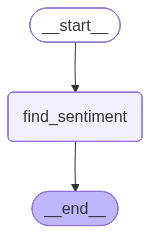

In [ ]:
# define graph

graph = StateGraph(ReviewState)

# add nodes
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('negative_response',negative_response)


# add edges
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis',negative_response)
graph.add_edge('negative_response',END)

workflow =  graph.compile()
workflow

In [ ]:
initial_state = {
    'review': "I've been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial Great job to the design team!"
}

workflow.invoke(initial_state)